# Calendar Features

This notebook aims to explore the impact of calendar features on sales. Questions this notebook aims to answer include: 
1. How does calendar features impact sales for items in different departments?
2. Are the created correlation features a reliable indicator of calendar effects on the specific items?

An important piece of information is that 2011 is not a complete date. This is what was driving the odd rolling averages. I need to fix this everywhere. 
Like wise I have learned that the last month (2016-03) is incomplete. I will filter it now. 

In [2]:
# Import required libraries
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(project_root)

# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

sales_query = """
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_monthly_sales,
        tgt.tgt_monthly_sales_sum_3_next_months
    FROM `porygon-pipelines.walmart_targets_and_filters.target_store_item_monthly` tgt
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON tgt.ctx_item_id = stckt.ctx_item_id
        AND tgt.ctx_store_id = stckt.ctx_store_id
        AND tgt.ctx_date_month = stckt.ctx_date_month
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND stckt.is_stockout_tgt = 0
"""

calendar_features_query = """
    SELECT 
        *
    FROM `porygon-pipelines.walmart_featurestore.calendar_features`
"""
# Extract data
item_sales = bq_client.load_from_query(sales_query)
calendar_features = bq_client.load_from_query(calendar_features_query)

item_sales = item_sales[item_sales["tgt_monthly_sales"]>0]
item_sales = item_sales[
    (item_sales["ctx_date_month"]>=pd.to_datetime("2011-02-01"))
    & (item_sales["ctx_date_month"]<=pd.to_datetime("2016-02-01"))
     ]

# Merge dataframes on 'ctx_date_month'
df_merged = item_sales.merge(
    calendar_features,
    on="ctx_date_month",
)

calendar_correlation_features_query = """
    SELECT 
        *
    FROM `porygon-pipelines.walmart_featurestore.calendar_correlations`
    WHERE ctx_store_id = "CA_1"
"""
calendar_correlation_features = bq_client.load_from_query(calendar_correlation_features_query)

df_merged_correlations = df_merged.merge(
    calendar_correlation_features,
    on=["ctx_date_month","ctx_item_id"]
)



INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 121003 rows from custom query.
INFO:src.core.clients.bigquery:Loaded 121003 rows from custom query.
INFO:src.core.clients.bigquery:Loaded 66 rows from custom query.
INFO:src.core.clients.bigquery:Loaded 66 rows from custom query.
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fet

# Utils functions



In [3]:
def plot_effect_on_tgt_per_dept_list(dept_list, feature_name, target_name="tgt_monthly_sales_sum_3_next_months"):
    import numpy as np
    departments = np.array(dept_list)
    quantiles = [0.25, 0.5, 0.75]
    nrows = len(departments)//2 + len(departments)%2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 5*nrows))  # Increased vertical space
    axes = axes.flatten()

    for i, dept in enumerate(departments):
        ax = axes[i]
        df_dept = df_merged[df_merged['ctx_dept_id'] == dept]
        q_df = df_dept.groupby(feature_name)[[target_name]].quantile(quantiles).reset_index().pivot(
            index=feature_name, columns='level_1', values=target_name)
        q_df.plot(ax=ax, marker='o')
        ax.set_title(f"{dept} - Sales Quantiles by {feature_name}")
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Sales')
        ax.legend([f"Q{int(q*100)}" for q in quantiles])
        ax.grid(True)

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(h_pad=3.0)  # Add more vertical padding
    plt.show()

# Create regression iteration function
def iterate_regression_over_features_and_departments(event_cols, target_name = "tgt_monthly_sales_sum_3_next_months"):
    results = {}
    significant_results = []
    for event_col in event_cols:
        df_merged[event_col] = df_merged[event_col].fillna(0)
        df_merged[event_col] = df_merged[event_col].astype(float)
        for dept in df_merged['ctx_dept_id'].unique():
            dept_df = df_merged[df_merged['ctx_dept_id'] == dept].copy()
            X = dept_df[event_col]
            X = sm.add_constant(X)
            y = dept_df[target_name]
            model = sm.OLS(y, X, missing='drop').fit()
            results[dept+"-"+event_col] = model
            coef = model.params.get(event_col, None)
            pval = model.pvalues.get(event_col, None)
            if coef is not None and pval is not None and pval < 0.06:
                significant_results.append({'department': dept, 'coef': coef, 'p_value': pval, 'feature': event_col})
    df_significant = pd.DataFrame(significant_results)
    df_significant["abs_coef"] = df_significant["coef"].abs()
    return results, df_significant


def plot_calendar_against_month_sin(feature_name):
    fig, ax1 = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df_merged, x='ctx_date_month', y=feature_name, marker='o', ax=ax1, color='tab:blue', label=feature_name)
    ax1.set_ylabel(feature_name, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    sns.lineplot(data=df_merged, x='ctx_date_month', y='fea_month_sin', marker='o', ax=ax2, color='tab:orange', label='month_sin')
    ax2.set_ylabel('fea_month_sin', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    ax1.set_title(f'{feature_name} and fea_month_sin over Time')
    ax1.set_xlabel('Month')
    fig.tight_layout()
    plt.show()


# Regression per dept

In [4]:
EVENT_COLS = [ 'fea_is_weekend_3m', 'fea_is_event_1_3m', 'fea_is_event_2_3m',
       'fea_is_sporting_event_3m', 'fea_is_cultural_event_3m',
       'fea_is_national_event_3m']

results, df_significant = iterate_regression_over_features_and_departments(event_cols=EVENT_COLS, target_name = "tgt_monthly_sales_sum_3_next_months")



In [5]:
display(df_significant.sort_values(by='feature', ascending = False))

,department,coef,p_value,feature,abs_coef
0,FOODS_3,17.983243,0.013536,fea_is_weekend_3m,17.983243
1,HOBBIES_1,8.669854,0.025005,fea_is_weekend_3m,8.669854
2,HOUSEHOLD_1,5.108682,0.022350,fea_is_weekend_3m,5.108682
3,HOUSEHOLD_2,2.667251,0.000432,fea_is_weekend_3m,2.667251
12,HOBBIES_2,-5.897855,0.000271,fea_is_sporting_event_3m,5.897855
11,HOUSEHOLD_2,1.166110,0.009149,fea_is_sporting_event_3m,1.166110
10,FOODS_3,9.015570,0.041926,fea_is_sporting_event_3m,9.015570
9,FOODS_1,7.921653,0.030529,fea_is_sporting_event_3m,7.921653
13,FOODS_1,-5.110030,0.016781,fea_is_national_event_3m,5.110030
14,FOODS_2,3.785410,0.033378,fea_is_national_event_3m,3.785410


## Feature Is National Event

I decided to start with this one because it is affecting the largest number of departments (5).

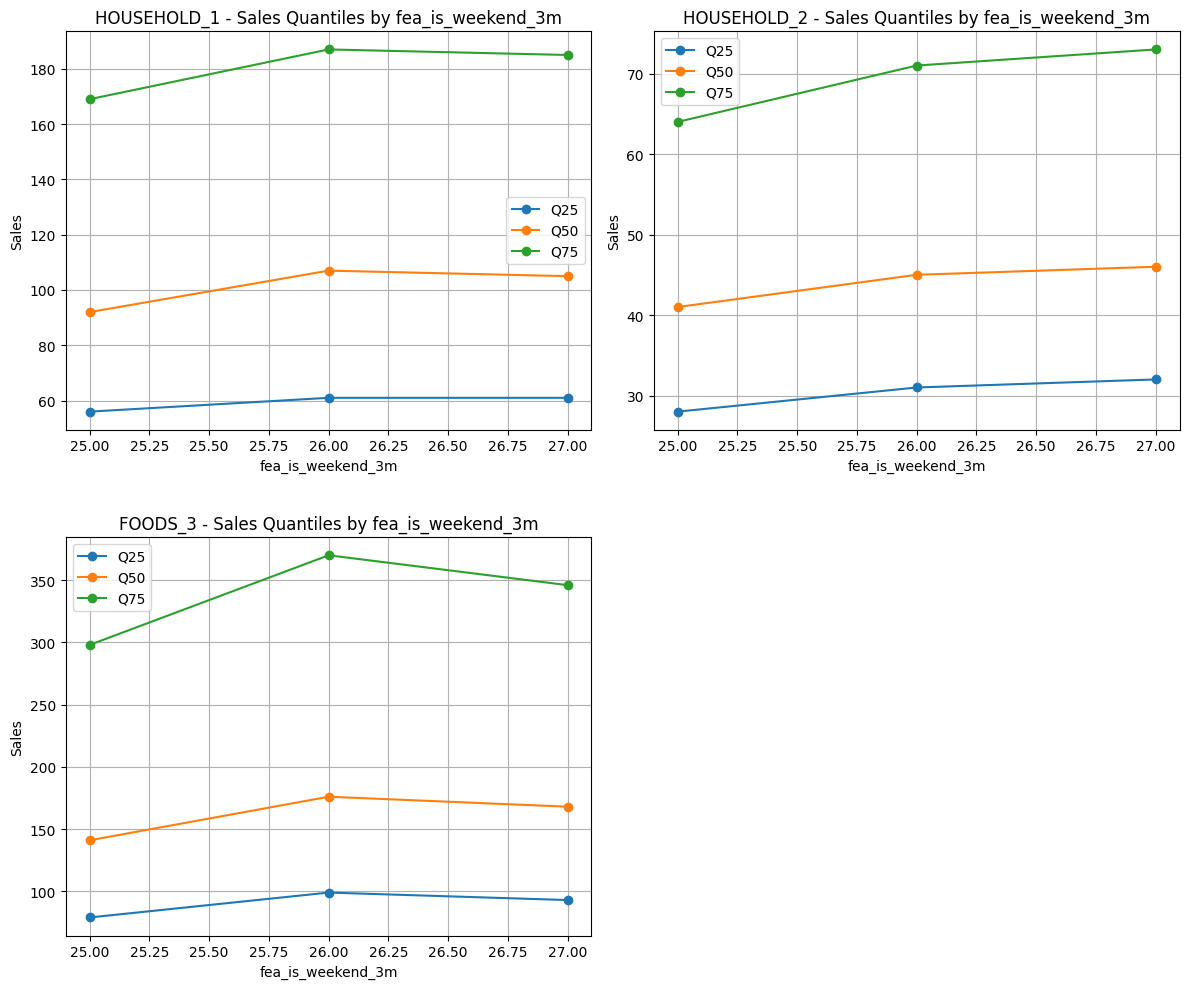

In [19]:
plot_effect_on_tgt_per_dept_list(
    dept_list=["HOUSEHOLD_1", "HOUSEHOLD_2", "FOODS_3"], 
    feature_name = "fea_is_weekend_3m"
)


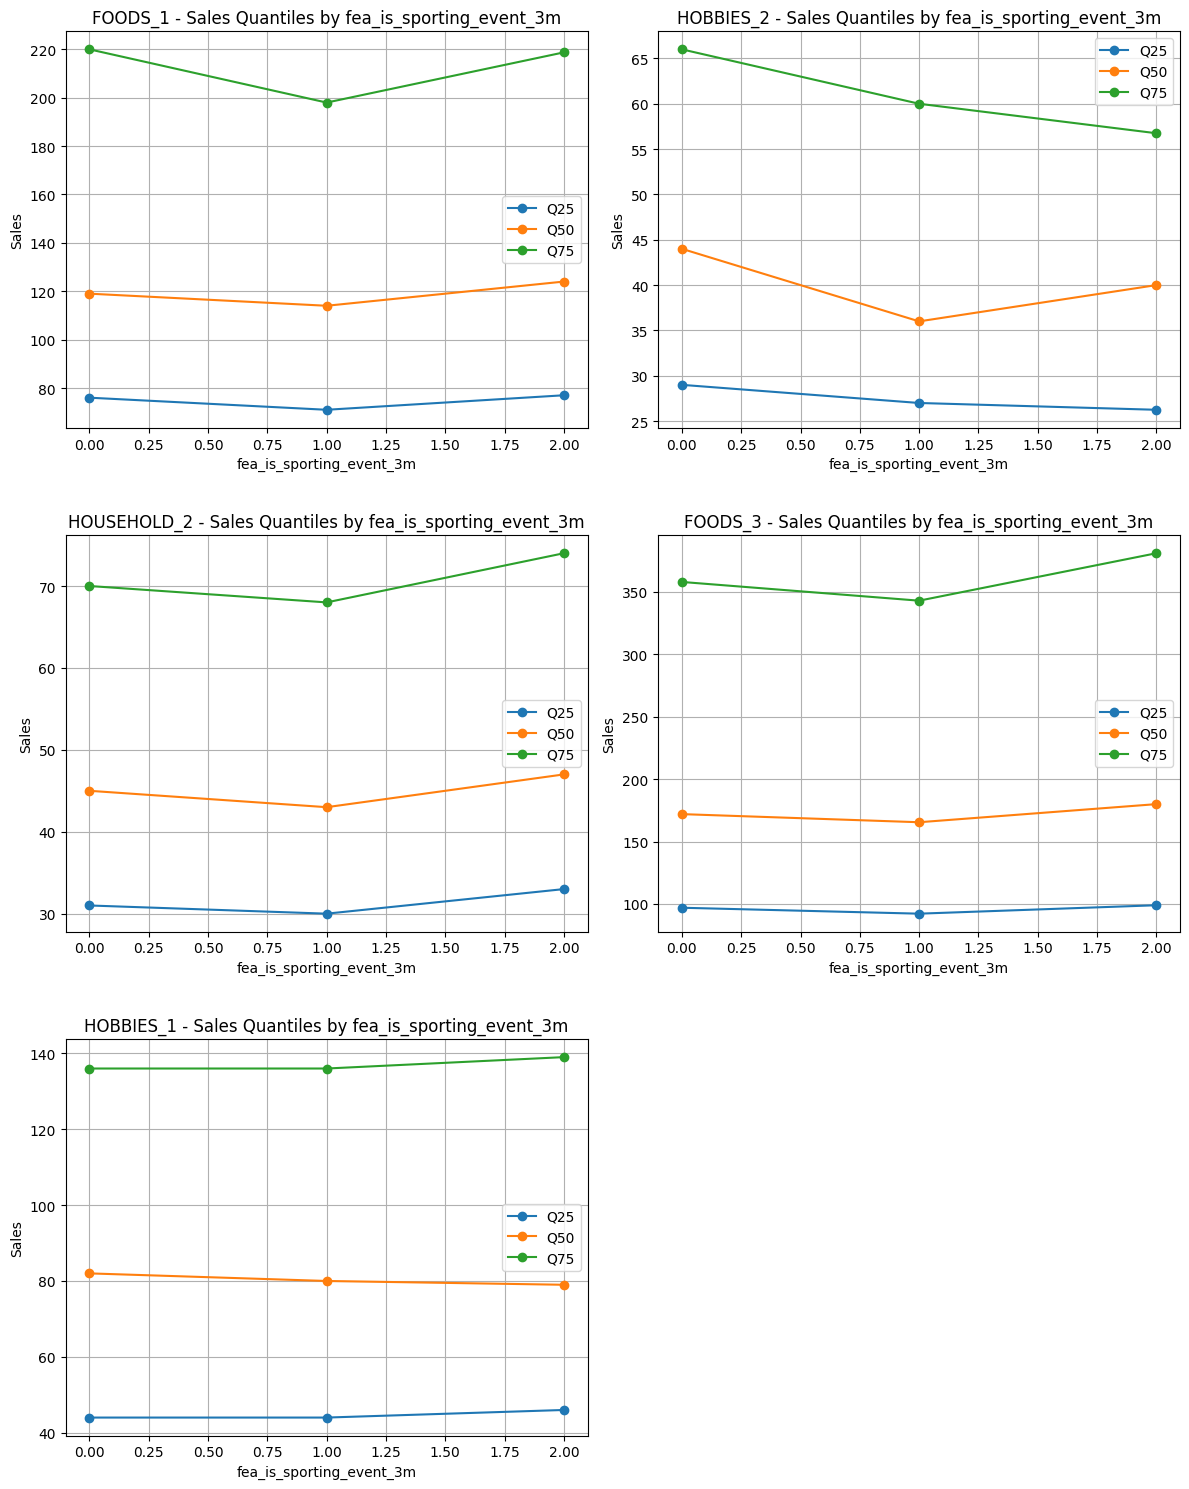

In [20]:
plot_effect_on_tgt_per_dept_list(
    dept_list=["FOODS_1", "HOBBIES_2", "HOUSEHOLD_2", "FOODS_3","HOBBIES_1"], 
    feature_name = "fea_is_sporting_event_3m"
)


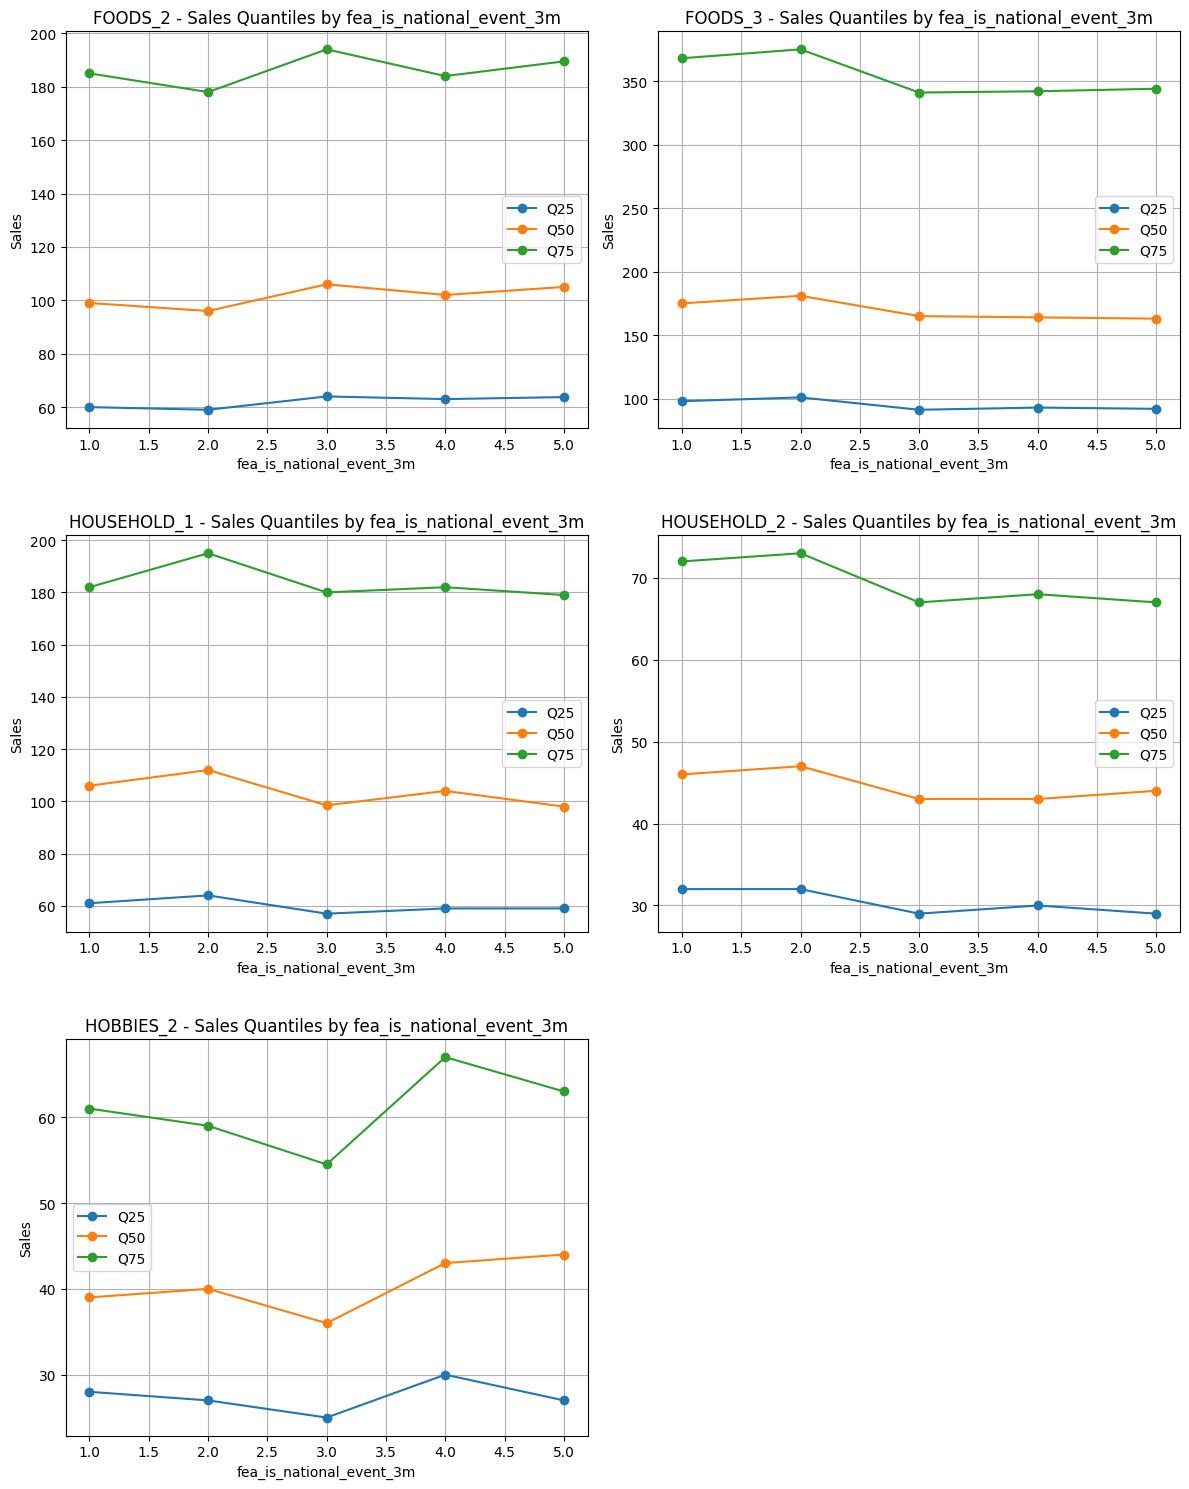

In [21]:
plot_effect_on_tgt_per_dept_list(
    dept_list=["FOODS_2", "FOODS_3", "HOUSEHOLD_1", "HOUSEHOLD_2","HOBBIES_2"], 
    feature_name = "fea_is_national_event_3m"
)

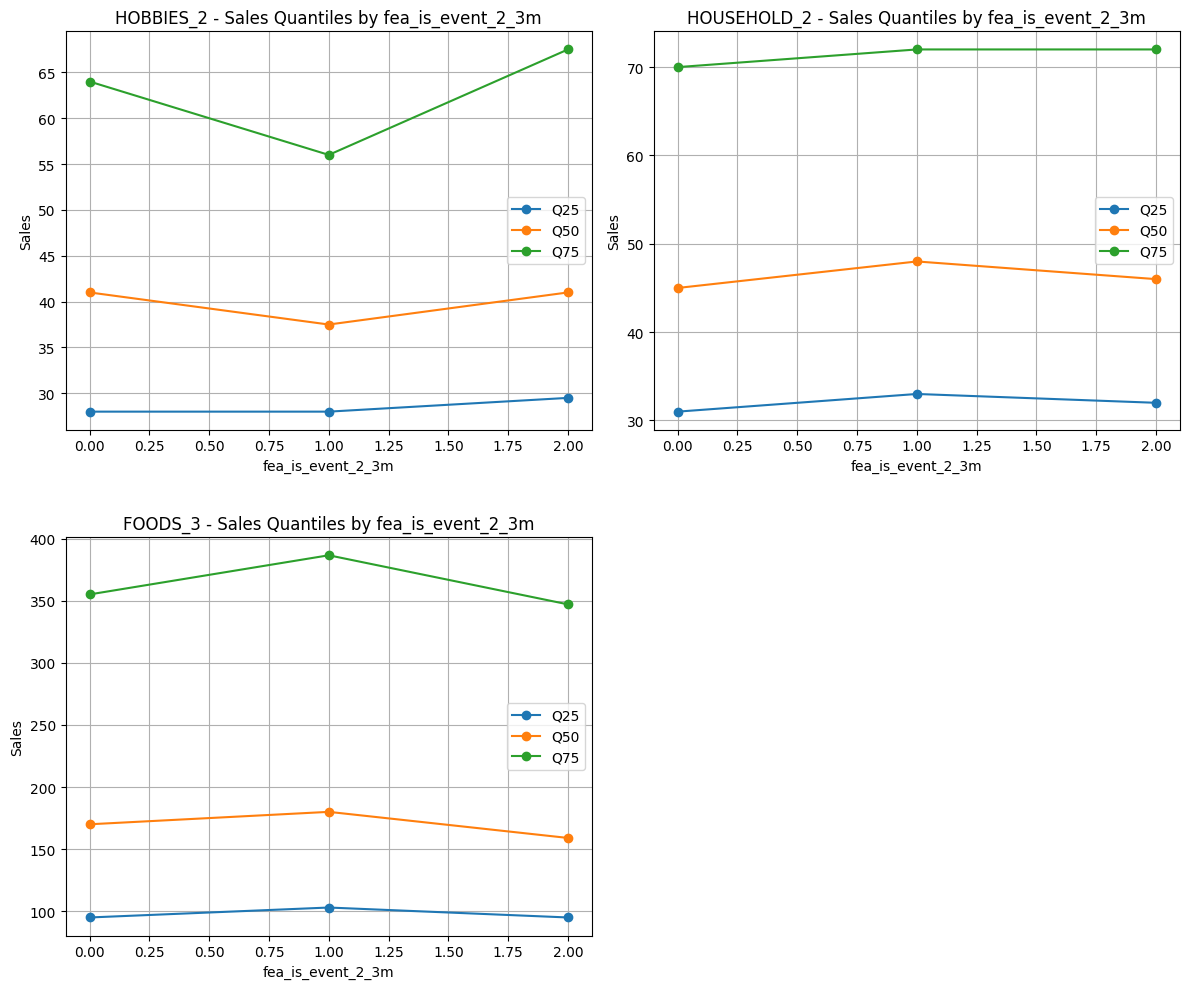

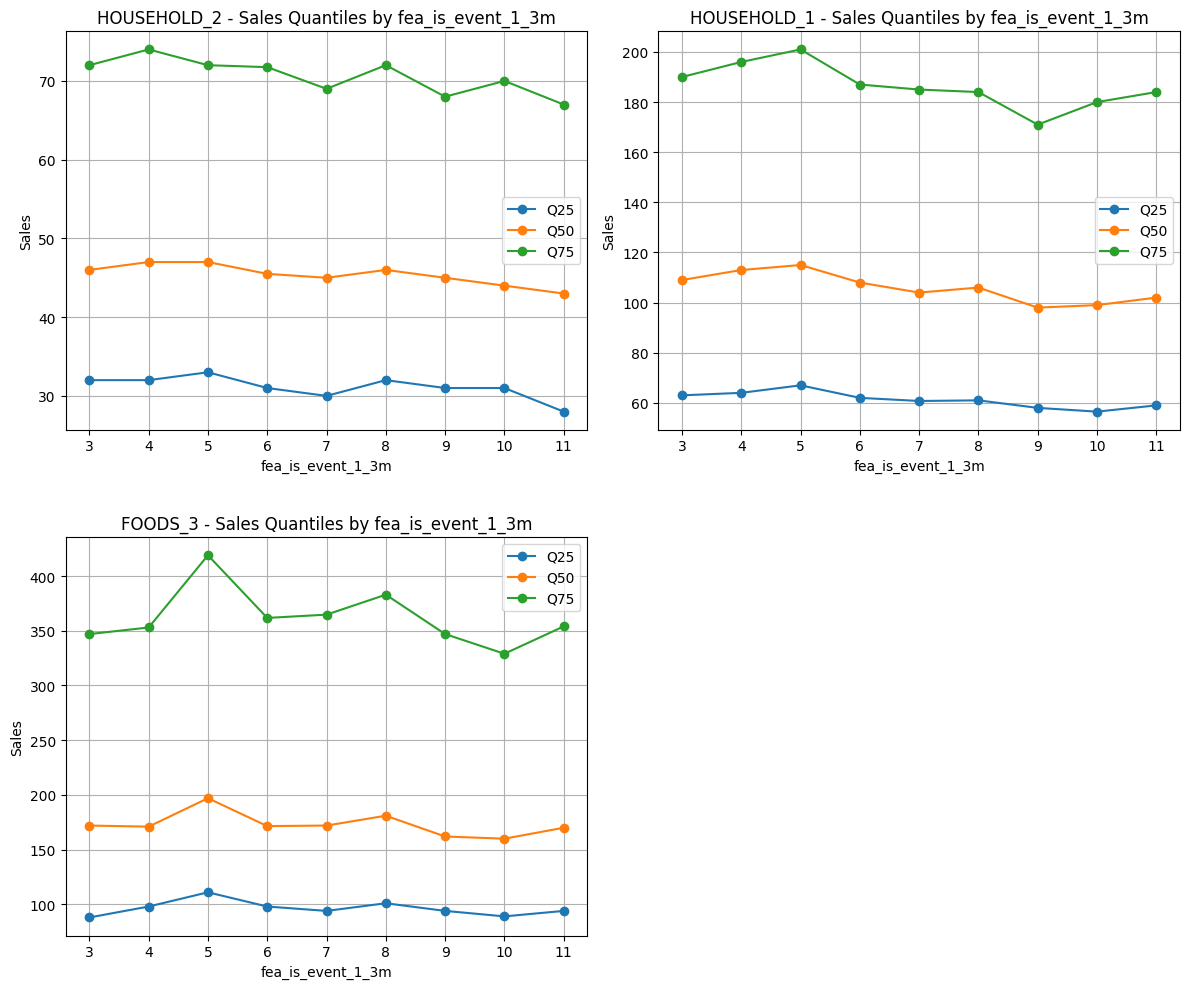

In [22]:
plot_effect_on_tgt_per_dept_list(
    dept_list=["HOBBIES_2", "HOUSEHOLD_2", "FOODS_3"], 
    feature_name = "fea_is_event_2_3m"
)
# it might be worth it to investigate what is this event 2 listed. 

plot_effect_on_tgt_per_dept_list(
    dept_list=["HOUSEHOLD_2", "HOUSEHOLD_1", "FOODS_3"], 
    feature_name = "fea_is_event_1_3m"
)
# it might be worth it to investigate what is this event 2 listed. 
# I am not personally so much of a fan of these aggreagted "is event" 
# because it does not say anything about the nature of the event.

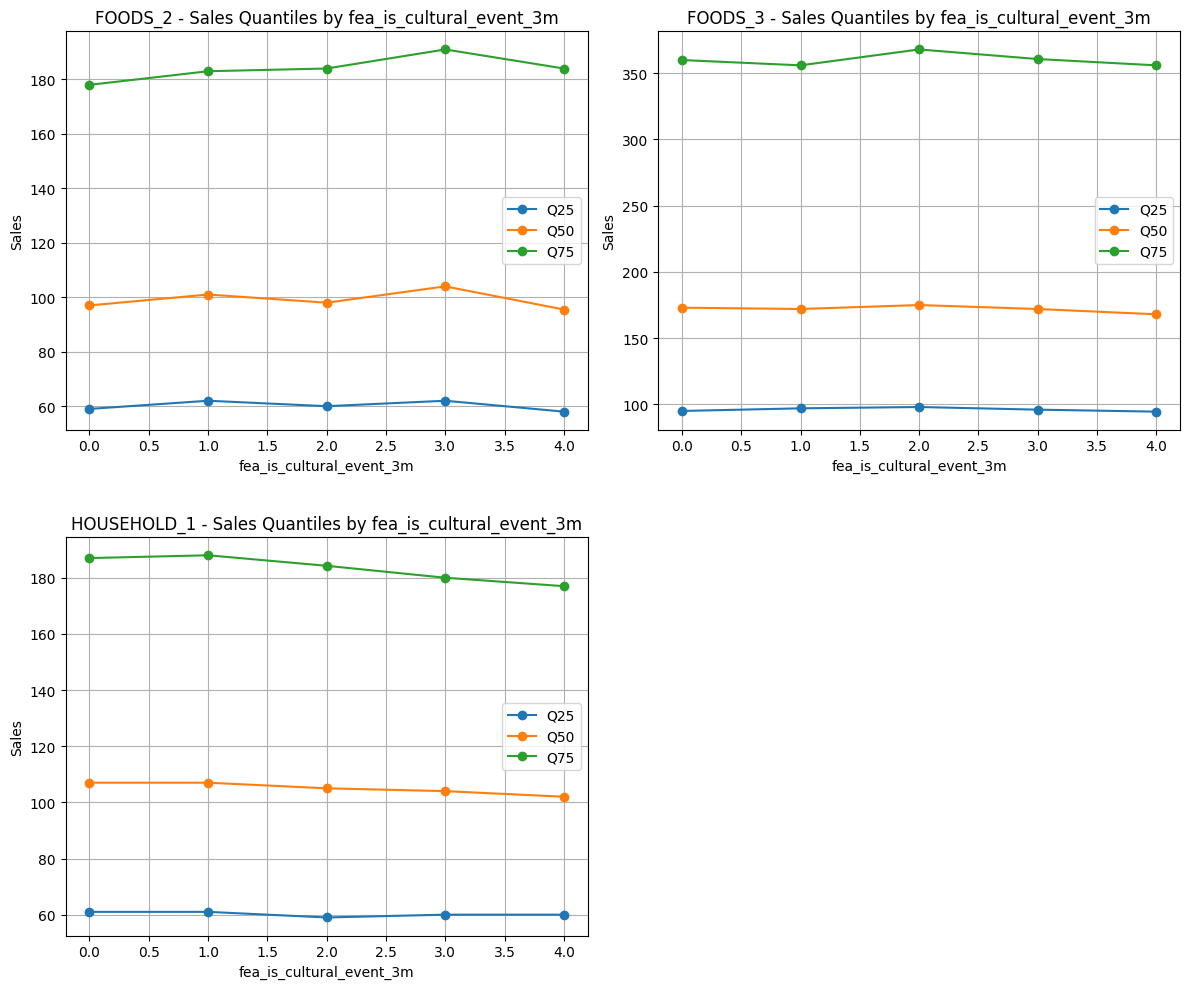

In [23]:
plot_effect_on_tgt_per_dept_list(
    dept_list=["FOODS_2", "FOODS_3", "HOUSEHOLD_1"], 
    feature_name = "fea_is_cultural_event_3m"
)

# Lets see the seasonality of these events:

Here it is very easy to see how related sporting events is related to the feature I had for monthly seasonality.
National event is almost an inverted version of the feature of seasonality. 
Cultural event is very similar tin its movements too. 

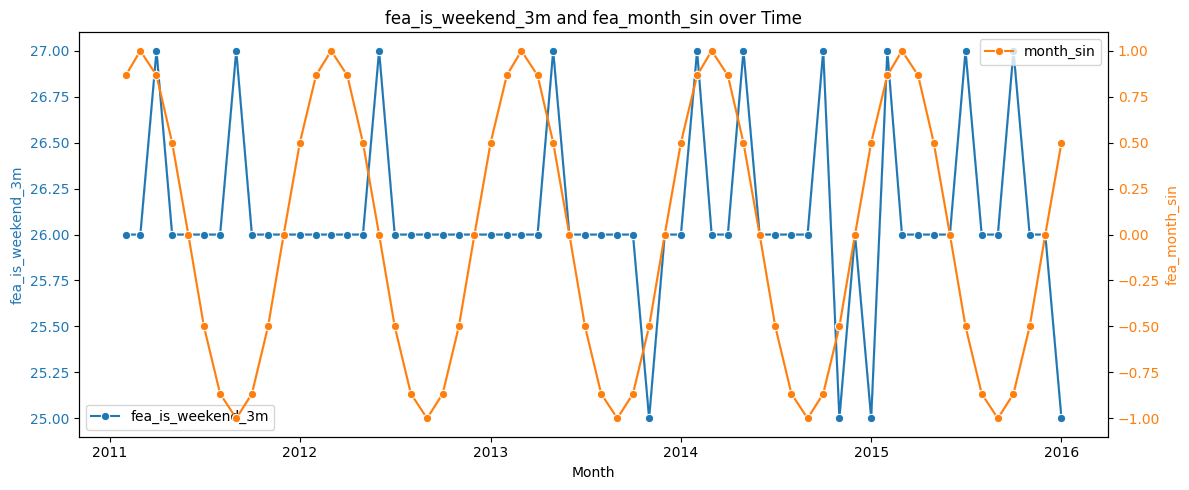

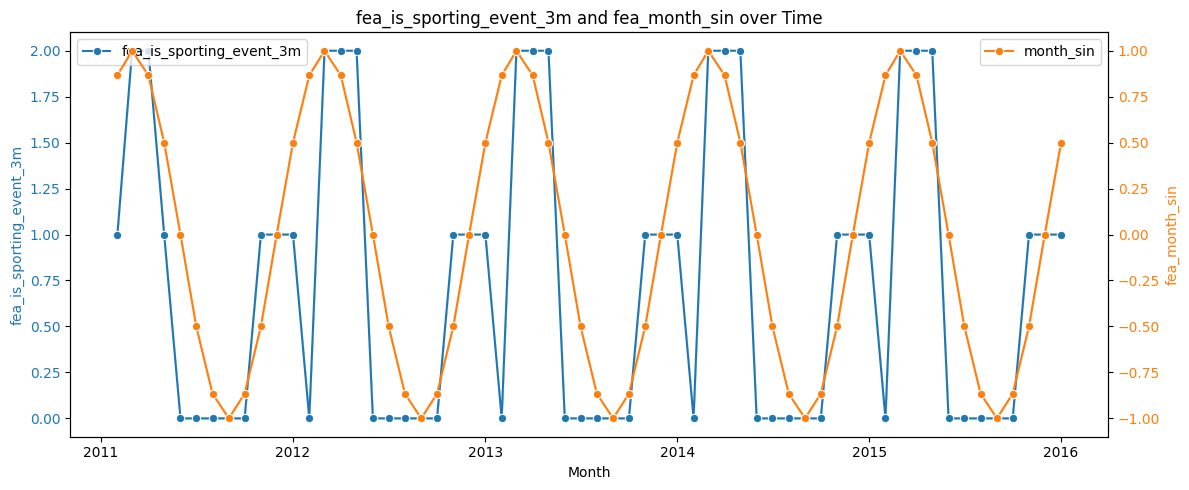

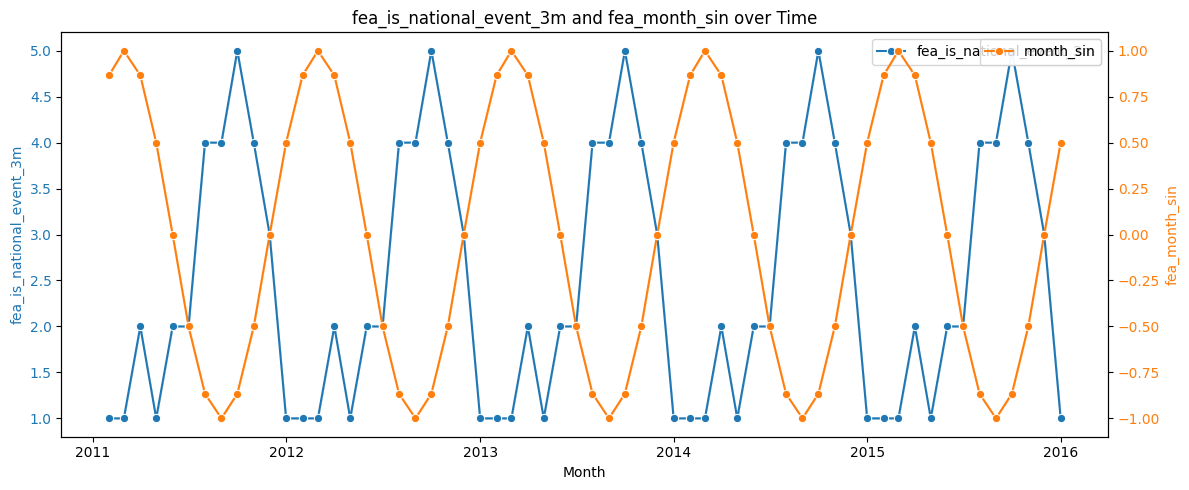

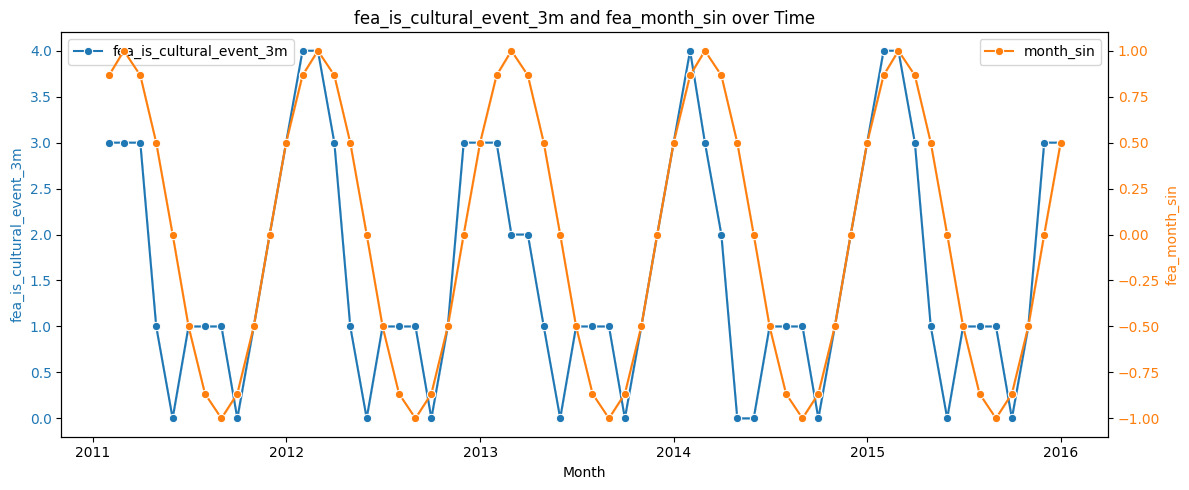

In [24]:
plot_calendar_against_month_sin("fea_is_weekend_3m")
plot_calendar_against_month_sin("fea_is_sporting_event_3m")
plot_calendar_against_month_sin("fea_is_national_event_3m")
plot_calendar_against_month_sin("fea_is_cultural_event_3m")

# Exploring a better way to tell the model which items are affected

My first instinct is to change this to use 3 months as opposed to current sales and then lag it. 
The indicator means nothing at the moment as is. 

At the individual level:
1. fea_is_weekend_3m: Would apply to only one item id consistently.
2. fea_is_sporting_event_3m: Would apply to only 142 item ids individually.
3. fea_is_cultural_event_3m: Would apply to only 188 item ids individually.
4. fea_is_national_event_3m: Would apply to 345 item ids indivdually.

In [27]:
feature_name = "fea_is_national_event_3m"
df_merged_correlations[feature_name] = df_merged_correlations[feature_name].fillna(0)
df_merged_correlations[feature_name] = df_merged_correlations[feature_name].astype(float)
significant_results = []
for item in df_merged_correlations["ctx_item_id"].unique():
    df_specific_item = df_merged_correlations[df_merged_correlations["ctx_item_id"] == item]
    unique_dates = df_specific_item["ctx_date_month"].unique()
    for cutoff_date in unique_dates:
        df_specific_item_cutoff = df_specific_item[df_specific_item["ctx_date_month"] <= cutoff_date]
        if df_specific_item_cutoff.shape[0]>=12:
            X = df_specific_item_cutoff[[feature_name]]
            X = sm.add_constant(X)
            y = df_specific_item_cutoff['tgt_monthly_sales_sum_3_next_months']
            model = sm.OLS(y, X).fit()
            pval = model.pvalues[feature_name]
            if pval < 0.05:
                significant_results.append({
                    'ctx_item_id': item, 
                    f'{feature_name}_p_value': pval, 
                    f'{feature_name}_coef': model.params[feature_name],
                    'ctx_date_month_cutoff': cutoff_date})

import pandas as pd
df_significant = pd.DataFrame(significant_results)

In [ ]:
# Fix: add 3 months to ctx_date_month_cutoff using pd.DateOffset
import pandas as pd

df_significant["ctx_date_month"] = pd.to_datetime(df_significant["ctx_date_month_cutoff"]) + pd.DateOffset(months=3)
df_merged["ctx_date_month"] = pd.to_datetime(df_merged["ctx_date_month"])
df_merged_significant = df_merged.merge(
    df_significant[['ctx_item_id', 'ctx_date_month',  f'{feature_name}_p_value', f'{feature_name}_coef']],
    on=['ctx_item_id', 'ctx_date_month'],
    how='left'
)

df_merged_significant[f"{feature_name}_nonnull"] = 0
df_merged_significant.loc[
    ~df_merged_significant[f"{feature_name}_p_value"].isna(),
    f"{feature_name}_nonnull"
] = 1

df_reliable_3m = df_merged_significant.groupby(
    ["ctx_item_id"]
)[[f"{feature_name}_nonnull"]].mean().sort_values(by=f"{feature_name}_nonnull", ascending=False).reset_index()

df_reliable_3m = df_reliable_3m[
    df_reliable_3m[f"{feature_name}_nonnull"]>0.50
]

df_merged_significant_filtered = df_merged_significant.merge(
    df_reliable_3m[["ctx_item_id"]],
    on="ctx_item_id",
    how="inner"
)

df_merged_significant_filtered[["ctx_item_id", "ctx_dept_id"]].drop_duplicates().shape